# Topic Modeling


Topic Modelling is one of the techniques used to conduct text analysis. As the name suggests, this method is used to find various topics that are present in the corpus. The idea is that each document in the corpus is made up of one or more than one topic and each topic is built from a bag of words. 

This notebook covers one of the most popular technique of Topic Modelling, **Latent Dirichlet Allocation**. This method was specifically designed for text data. 

As mentioned earlier, Topic Modelling is conducted on a bag of words and this is represented with a **document term matrix** of the entire corpus. 

In brief, LDA is uses probability distribution under the hood for the each word and..............


## Library Imports

In [1]:
# Import Os to get to the root directory
import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

# Import own functions
from libraries import corpus
from libraries import pdf2text
import spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable =['parser', 'ner'])
import re, numpy as np, pandas as pd
from pprint import pprint

#gensim
import gensim
import gensim, spacy, logging, warnings
from gensim import corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

#nltk
import nltk as nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from nltk.stem.wordnet import WordNetLemmatizer
import string

#other imports
import warnings
from importlib import reload
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Data Preprocessing

In [2]:
#import dataset
reload(corpus)

<module 'libraries.corpus' from 'C:\\Users\\sj\\Documents\\GitHub\\datascience_project\\libraries\\corpus.py'>

In [3]:
dataset = pdf2text.get_dataset()

2019-06-17 15:04:33,146 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2019-06-17 15:04:33,146 : WARNING : Failed to see startup log message; retrying...
2019-06-17 15:04:38,163 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2019-06-17 15:04:38,163 : WARNING : Failed to see startup log message; retrying...


In [4]:
dataset.keys()

dict_keys(['0chain', '0x', '1world', '1x2coin', 'ab-chain', 'abbccoin', 'abcccoin', 'able', 'absolute', 'ace', 'achain', 'acrecoin', 'actinium', 'acuteangle', 'adamant', 'adbank', 'adchainregistry', 'adcoin', 'adhive', 'aditus', 'adshares', 'aion', 'ample!', 'apollocurrency', 'ardor', 'ark', 'basicattentiontoken', 'bhpcoin', 'binancecoin', 'bitcoin', 'bitcoindiamond', 'bitcoingold', 'bitshares', 'bitstash', 'bittorrent', 'budbo', 'bytecoin', 'bytom', 'celernetwork', 'chainlink', 'cosmos', 'crypto', 'cryptonex', 'cryptonote', 'dai', 'dash', 'decentraland', 'dent', 'digixdao', 'dogecoin', 'elastos', 'enjincoin', 'eos', 'etherace', 'ethereum', 'ethereumclassic', 'factom', 'fantom', 'giant', 'givecoin', 'gnosis', 'golem', 'guaranteedentrancetoken', 'gxchain', 'holo', 'horizen', 'hypercash', 'hyperion', 'icon', 'inocoin', 'iota', 'japancontenttoken', 'komodo', 'kwattcoin', 'latoken', 'loopring', 'maidsafecoin', 'maker', 'medibloc', 'metal', 'metaverseetp', 'mixin', 'monerov', 'nano', 'nebul

In [6]:
corpora = corpus.makeCleanCorpus(dataset, lemmatize=False, removePunct=True, removeNums=True,makeSentences=True, removeURL=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading en_core_web_md: Package 'en_core_web_md' not
[nltk_data]     found in index


Cleaning: 0chain
Cleaning: 0x
Cleaning: 1world
Cleaning: 1x2coin
Cleaning: ab-chain
Cleaning: abbccoin
Cleaning: abcccoin
Cleaning: able
Cleaning: absolute
Cleaning: ace
Cleaning: achain
Cleaning: acrecoin
Cleaning: actinium
Cleaning: acuteangle
Cleaning: adamant
Cleaning: adbank
Cleaning: adchainregistry
Cleaning: adcoin
Cleaning: adhive
Cleaning: aditus
Cleaning: adshares
Cleaning: aion
Cleaning: ample!
Cleaning: apollocurrency
Cleaning: ardor
Cleaning: ark
Cleaning: basicattentiontoken
Cleaning: bhpcoin
Cleaning: binancecoin
Cleaning: bitcoin
Cleaning: bitcoindiamond
Cleaning: bitcoingold
Cleaning: bitshares
Cleaning: bitstash
Cleaning: bittorrent
Cleaning: budbo
Cleaning: bytecoin
Cleaning: bytom
Cleaning: celernetwork
Cleaning: chainlink
Cleaning: cosmos
Cleaning: crypto
Cleaning: cryptonex
Cleaning: cryptonote
Cleaning: dai
Cleaning: dash
Cleaning: decentraland
Cleaning: dent
Cleaning: digixdao
Cleaning: dogecoin
Cleaning: elastos
Cleaning: enjincoin
Cleaning: eos
Cleaning: ether

In [7]:
corpora['oceanprotocol'][:5]

['decentralized substrate services technical foundation ltd version apr abstract paper presents ',
 'decentralized protocol nerk artificial intelligence dataservices ',
 'aims spread benefits unlocking data preserving privacy ',
 'helps power marketplaces buysell data services software publish access commons data data science tools consume data ',
 'decentralized orchestration core decentralized service agreements decentralized access control execute decentralized virtual machines ']

In [8]:
#Our dictionary at the moment is in key: blockchain firms, value: list of text of whitepapers
#We change this to key: blockchain firms and value: string format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [9]:
#Combining then
data_combined = {key:[combine_text(value)] for (key, value) in corpora.items()}

In [10]:
#Putting the text into pandas dataframe
import pandas as pd
pd.set_option('max_colwidth', 150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['whitepapers']
data_df = data_df.sort_index()

In [11]:
#Glancing into Ocean Protocol Whitepaper
data_df.whitepapers.loc['oceanprotocol']

'decentralized substrate services technical foundation ltd version apr abstract paper presents  decentralized protocol nerk artificial intelligence dataservices  aims spread benefits unlocking data preserving privacy  helps power marketplaces buysell data services software publish access commons data data science tools consume data  decentralized orchestration core decentralized service agreements decentralized access control execute decentralized virtual machines  allows connection mtization curation arbitrary data services  adds nerk rewards incentivize data sharing including privacypreserving data commons  technical intended accompany published foundation ltd information memorandum  accordingly technical intended read conjunction subject legal disclaimers notices set information memorandum  oceanprotocolcom bigchaindbcom dexsg contents  overview introduction   proofofservice incentives  onchain bounties  tokens  context use cases   regulated medical research  stakeholders pricing de

In [12]:
#Pickling the data for future use. 
import pickle
#data_df.to_pickle('tmcorpus.pkl')

In [13]:
with open('tmcorpus.pkl', 'rb') as f:
    data_df = pickle.load(f)

### Document-Term Matrix

Since the goal of this notebook is Topic Modelling, the text must be tokenized which means broken down to small pieces which here is words. We use scikit-learn's CountVectorizer technique where every row represents a different document and every column will represent a different word. 

At this moment, stop words are also removed thanks to CountVectorizer. Stop words are common words that seldom adds meaning or value to the text. 


In [15]:
#Creating a document-term matrix using CountVectorizer, and removing common english stop words. 

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words ='english')
data_cv = cv.fit_transform(data_df.whitepapers)
data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
data_dtm.index = data_df.index
data_dtm

,aaab,aaafdfddddcaf,aack,aacks,aadbcfeedccfbdcfdca,aaddrask,aael,aagree,aagreeesk,aagreeivk,...,zurrer,zverify,zverifyingey,zverifyrt,zverifyvkx,zviews,zviewtestsapling,zxqzwpqhdnfwaxhuklhksirdwathdm,zxxxxxxxxxxxx,zygomys
0chain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1world,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1x2coin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ab-chain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abbccoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abcccoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absolute,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ace,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#pickling the document-term matrix
data_dtm.to_pickle('dtm.pkl')

In [17]:
#importing necessary modules for LDA and gensim
from gensim import matutils, models
import scipy.sparse
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

In [18]:
#importing the term-document matrix and converting it into document-term matrix with transpose

tdm = data_dtm.transpose()
tdm.head(5)

,0chain,0x,1world,1x2coin,ab-chain,abbccoin,abcccoin,able,absolute,ace,...,utrust,vechain,waltonchain,wanchain,waves,wax,xrp,zcash,zerocash,zilliqa
aaab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaafdfddddcaf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
aack,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aacks,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aadbcfeedccfbdcfdca,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
#Converting the term-document matrix into gensim corpus format which follows a sequence from dataframe to sparse matrix to gensim corpus
sparse_docs = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_docs)

In [20]:
#Creating term dictionary of our corpus, where every unique term is assigned an index
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [25]:
#lda time!!!

lda = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
lda.print_topics()

[(0,
  '0.008*"tokens" + 0.008*"token" + 0.007*"platform" + 0.007*"data" + 0.007*"blockchain" + 0.006*"technology" + 0.006*"market" + 0.006*"development" + 0.006*"users" + 0.005*"smart"'),
 (1,
  '0.027*"ned" + 0.017*"pend" + 0.014*"visited" + 0.013*"descriptions" + 0.012*"encoding" + 0.011*"url" + 0.011*"mut" + 0.010*"shied" + 0.009*"ignature" + 0.007*"beta"'),
 (2,
  '0.014*"nerk" + 0.012*"transaction" + 0.011*"nodes" + 0.009*"block" + 0.008*"transactions" + 0.007*"protocol" + 0.007*"consensus" + 0.006*"node" + 0.006*"time" + 0.006*"data"'),
 (3,
  '0.015*"new" + 0.013*"old" + 0.013*"transaction" + 0.011*"key" + 0.010*"coin" + 0.009*"coins" + 0.009*"pour" + 0.009*"public" + 0.008*"scheme" + 0.007*"transactions"'),
 (4,
  '0.017*"content" + 0.012*"nomin" + 0.012*"havven" + 0.010*"nomins" + 0.010*"advertising" + 0.009*"news" + 0.007*"publishers" + 0.007*"collateral" + 0.007*"publisher" + 0.007*"havvens"')]

## Visualization / Outcome

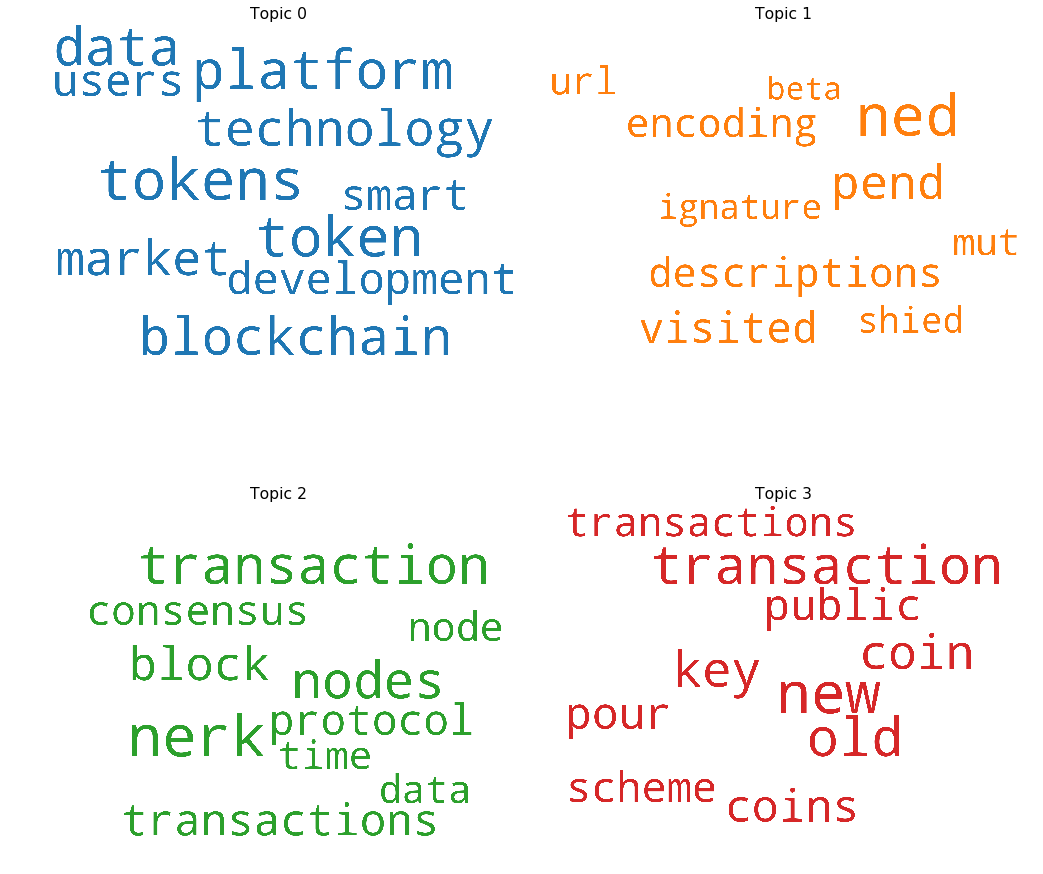

In [30]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True, dpi = 70)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

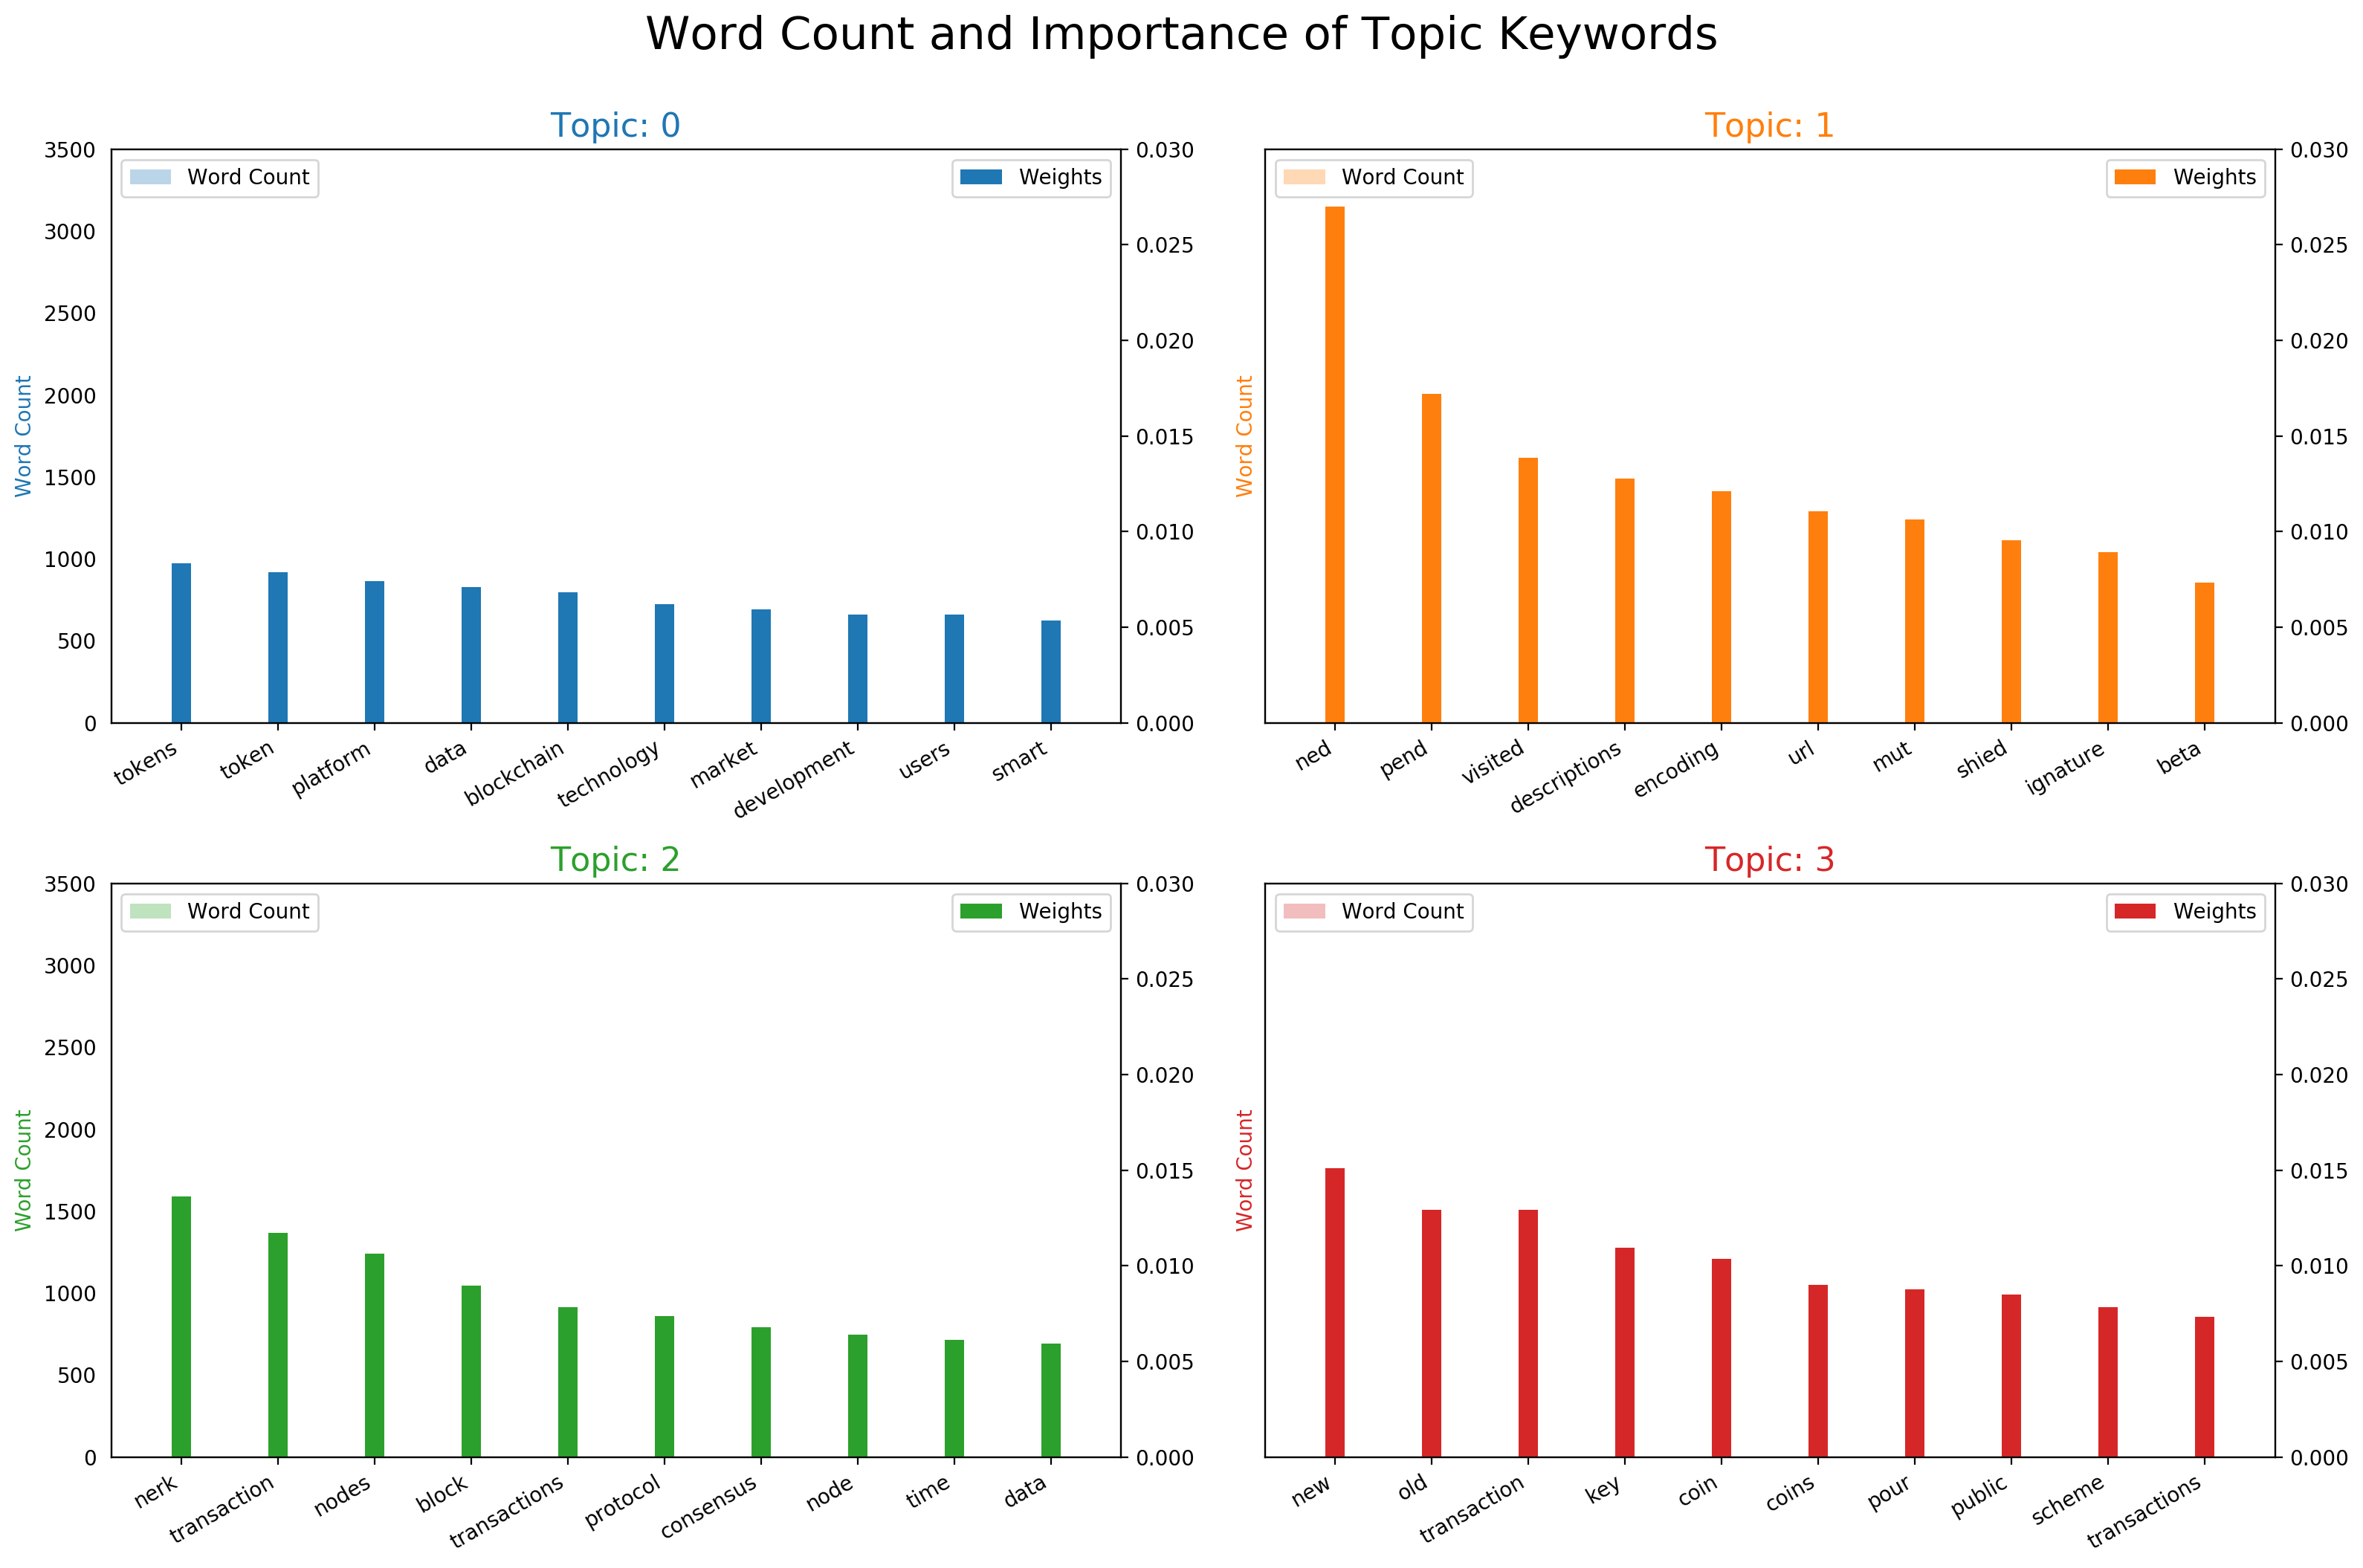

In [31]:
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=200)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Method Application

References:

https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

TopicModels_LDA Notebook from Prof. Markus Loecher